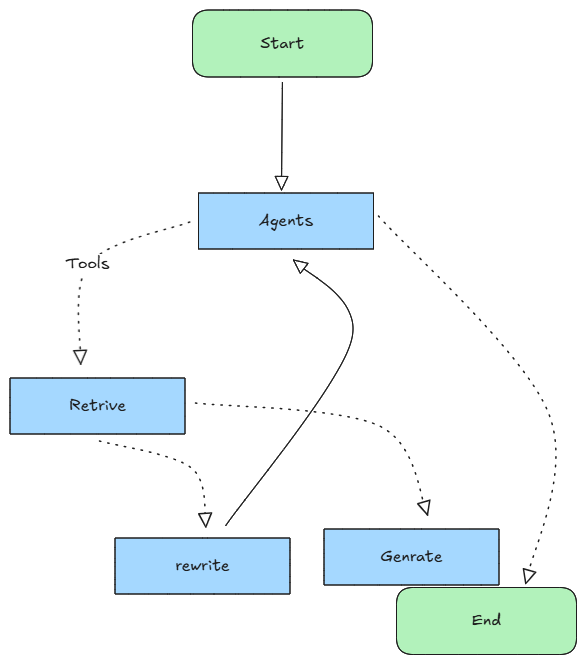
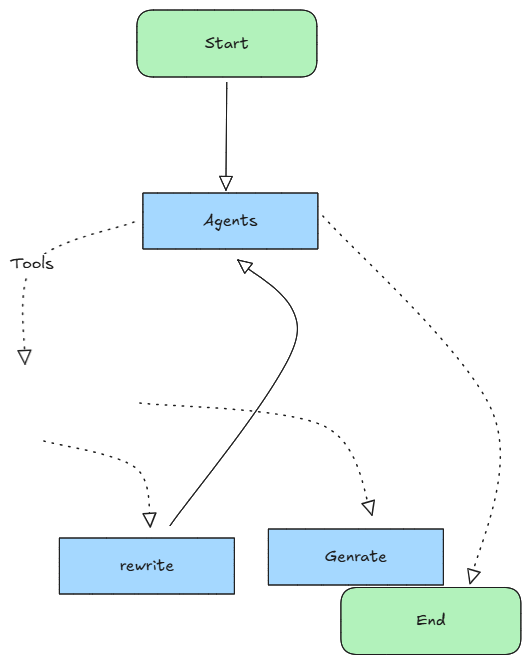

### Description of the usecase:

* 

In [2]:
!pip install -q langgraph==0.2.59
!pip install -q langchain_community
!pip install -q pypdf
!pip install -q langchain_openai
!pip install -q chromadb

In [24]:
import os
from dotenv import load_dotenv, find_dotenv
from typing import Annotated, Literal, Sequence, TypedDict
from pydantic import BaseModel, Field

from langchain import hub
from langchain.tools.retriever import create_retriever_tool
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

from langchain_community.document_loaders import PyPDFDirectoryLoader, PyPDFLoader
from langchain_community.vectorstores import Chroma

from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition


In [25]:

_ = load_dotenv(find_dotenv())

In [26]:
file_path = './pdfs/human-agent-collab-problem-solving.pdf'

docs = PyPDFLoader(file_path).load_and_split()

In [27]:
len(docs)

24

In [28]:
docs[0]

Document(metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2024-02-21T01:47:05+00:00', 'author': '', 'keywords': '', 'moddate': '2024-02-21T01:47:05+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'subject': '', 'title': '', 'trapped': '/False', 'source': './pdfs/human-agent-collab-problem-solving.pdf', 'total_pages': 16, 'page': 0, 'page_label': '1'}, page_content='Large Language Model-based Human-Agent Collaboration\nfor Complex Task Solving\nXueyang Feng1,2∗, Zhi-Yuan Chen1,2∗, Yujia Qin3, Yankai Lin1,2†\nXu Chen1,2†, Zhiyuan Liu3, Ji-Rong Wen1,2\n1Gaoling School of Artificial Intelligence, Renmin University of China, Beijing, China\n2 Beijing Key Laboratory of Big Data Management and Analysis Methods, Beijing, China\n3 Department of Computer Science and Technology, Tsinghua University, Beijing, China\n{xueyangfeng, zhiyuanc2001, yankailin, xu.chen}@ruc.edu.cn\nAbstract\nIn 

In [29]:
db = Chroma.from_documents(docs, OpenAIEmbeddings(model='text-embedding-3-small'))

In [30]:
# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=docs,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(model='text-embedding-3-small'),
)
retriever = vectorstore.as_retriever()

In [31]:
retriever_tool = create_retriever_tool(
    retriever,
    'retrieve_info_from_papers',
    'Search and return information about a paper discussing usage of LLMs for human collaborative problem solving.',
)

tools = [retriever_tool]

In [32]:
model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo")
model = model.bind_tools(tools)

In [33]:
resp = response = model.invoke("In this paper how do the authors set up the collaboration between the human and the LLMs?")

In [34]:
resp

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_ChfIunvjRWiJxGisw42tiIQ9', 'function': {'arguments': '{"query":"setup of collaboration between human and LLMs in problem solving"}', 'name': 'retrieve_info_from_papers'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_7c63087da1'}, id='run-ba82bee0-43a6-447d-880b-d499fd1400d3-0', tool_calls=[{'name': 'retrieve_info_from_papers', 'args': {'query': 'setup of collaboration between human and LLMs in problem solving'}, 'id': 'call_ChfIunvjRWiJxGisw42tiIQ9', 'type': 'tool_call'}])

In [35]:
class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [36]:

### Edges

def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"



In [37]:

### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    print("----MESSAGES----")
    print(messages)
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4-turbo")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    print("----RESPONSE----")
    print(response)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


In [38]:
print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [39]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

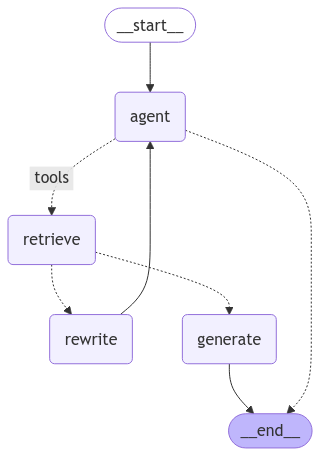

In [40]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [41]:
import pprint

In [42]:
import pprint

inputs = {
    "messages": [
        ("user", "In this paper how do the authors set up the collaboration between the human and the LLMs?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
----MESSAGES----
[HumanMessage(content='In this paper how do the authors set up the collaboration between the human and the LLMs?', additional_kwargs={}, response_metadata={}, id='950674c9-c228-4ebf-bae6-7b5912542b31')]
----RESPONSE----
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_uXBovnt6VpLWxYkPu3atfSXf', 'function': {'arguments': '{"query":"setup of collaboration between human and LLMs"}', 'name': 'retrieve_info_from_papers'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_7c63087da1'} id='run-f5f84d5f-3eb7-40ca-912a-6eb45281fb4c-0' tool_calls=[{'name': 'retrieve_info_from_papers', 'args': {'query': 'setup of collaboration between human and LLMs'}, 'id': 'call_uXBovnt6VpLWxYkPu3atfSXf', 'type': 'tool_call'}]
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_uXBovnt6VpLWxYk

/Users/sourav.banerjee/Documents/2. My Codebases/GenerativeAI-Demystified/venv/lib/python3.11/site-packages/langchain_openai/chat_models/base.py:1390: UserWarning: Cannot use method='json_schema' with model gpt-4-0125-preview since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='Wu et al., 2022a; Mehta et al., 2023). Further-\nmore, there is an increasing emphasis on develop-\ning specialized prompts that motivate LLM-based\nagents to proactively seek human input, thus nurtur-\ning a more interactive and collaborative dynamic\nin these partnerships (Huang et al., 2022; Wang\net al., 2023b). However, the effectiveness of these\nmethods relies on designing high-quality rules or\nprompts. This is highly dependent on the designer’s\ndomain knowledge. Poor design may result in a sys-\ntem that cannot accurately understand or respond to\ncomplex task requirements. Our research focuses\non designing a generalised and learnable method\nthat coordinates human to effectively work with\nLLM-based agents in the form of direct planning.\n6 Conclusion\nIn this paper, we propose the problem of large\nlanguage model-based human-agent collaboration,\ndelving into the synergy

In [21]:
import pprint

inputs = {
    "messages": [
        ("user", "In this paper how do the authors set up the collaboration between the human and the LLMs?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
----RESPONSE----
content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_FENc6MOI2TCgZtofUuoNmHf1', 'function': {'arguments': '{"query":"setup of collaboration between human and LLMs"}', 'name': 'retrieve_info_from_papers'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4-turbo-2024-04-09', 'system_fingerprint': 'fp_7c63087da1'} id='run-ec0c5629-24bc-488b-9c30-33c60bf8b996-0' tool_calls=[{'name': 'retrieve_info_from_papers', 'args': {'query': 'setup of collaboration between human and LLMs'}, 'id': 'call_FENc6MOI2TCgZtofUuoNmHf1', 'type': 'tool_call'}]
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_FENc6MOI2TCgZtofUuoNmHf1', 'function': {'arguments': '{"query":"setup of collaboration between human and LLMs"}', 'name': 'retrieve_info_from_papers'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_nam

/Users/sourav.banerjee/Documents/2. My Codebases/GenerativeAI-Demystified/venv/lib/python3.11/site-packages/langchain_openai/chat_models/base.py:1390: UserWarning: Cannot use method='json_schema' with model gpt-4-0125-preview since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='Wu et al., 2022a; Mehta et al., 2023). Further-\nmore, there is an increasing emphasis on develop-\ning specialized prompts that motivate LLM-based\nagents to proactively seek human input, thus nurtur-\ning a more interactive and collaborative dynamic\nin these partnerships (Huang et al., 2022; Wang\net al., 2023b). However, the effectiveness of these\nmethods relies on designing high-quality rules or\nprompts. This is highly dependent on the designer’s\ndomain knowledge. Poor design may result in a sys-\ntem that cannot accurately understand or respond to\ncomplex task requirements. Our research focuses\non designing a generalised and learnable method\nthat coordinates human to effectively work with\nLLM-based agents in the form of direct planning.\n6 Conclusion\nIn this paper, we propose the problem of large\nlanguage model-based human-agent collaboration,\ndelving into the synergy